In [1]:
import numpy as np
import pandas as pd
import pandas as np
import matplotlib.pyplot as plt
import seaborn as sns
import klib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import shap

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
data = pd.read_csv('제조업_target수정.csv', encoding='cp949')
data = data.drop(columns = ['ID', 'SQ4'])

In [3]:
data

,SQ2,SQ3,SQ5,Q1_1,Q1_2,Q1_3,Q1_4,Q2,Q3_1_1,Q3_1_2,...,Q19_3_4,Q22_1,Q22_2,Q28_1,Q28_2,Q28_3,Q30,Q31,Q31_1,target
0,2009,2,9,52,7,0,28,2,0,999,...,0.0,1,3.0,3,4.0,5.0,2,2,0.0,1
1,2001,1,1,20,2,1,7,2,0,999,...,0.0,3,9.0,6,4.0,3.0,2,2,0.0,0
2,2005,1,1,20,3,1,10,2,0,999,...,0.0,2,9.0,5,4.0,9.0,2,1,4.0,0
3,2003,1,1,30,1,2,16,2,0,999,...,0.0,1,3.0,6,7.0,8.0,2,2,0.0,0
4,2002,1,1,22,20,0,2,2,1,999,...,0.0,1,4.0,6,4.0,5.0,1,1,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3250,2010,2,13,69,10,2,4,2,0,999,...,80.0,1,4.0,5,6.0,7.0,2,1,4.0,0
3251,1991,3,16,100,18,19,26,1,14,999,...,0.0,1,4.0,2,6.0,8.0,1,1,5.0,0
3252,1999,5,16,768,89,0,35,1,0,999,...,0.0,1,4.0,3,4.0,1.0,1,1,4.0,1
3253,2018,1,7,48,16,8,19,2,0,999,...,5.0,1,3.0,3,2.0,4.0,1,1,3.0,1


In [13]:
y = data['target']
X = data.drop(columns='target')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, pred)

In [15]:
score

0.7253439557024607

#### target과의 상관관계

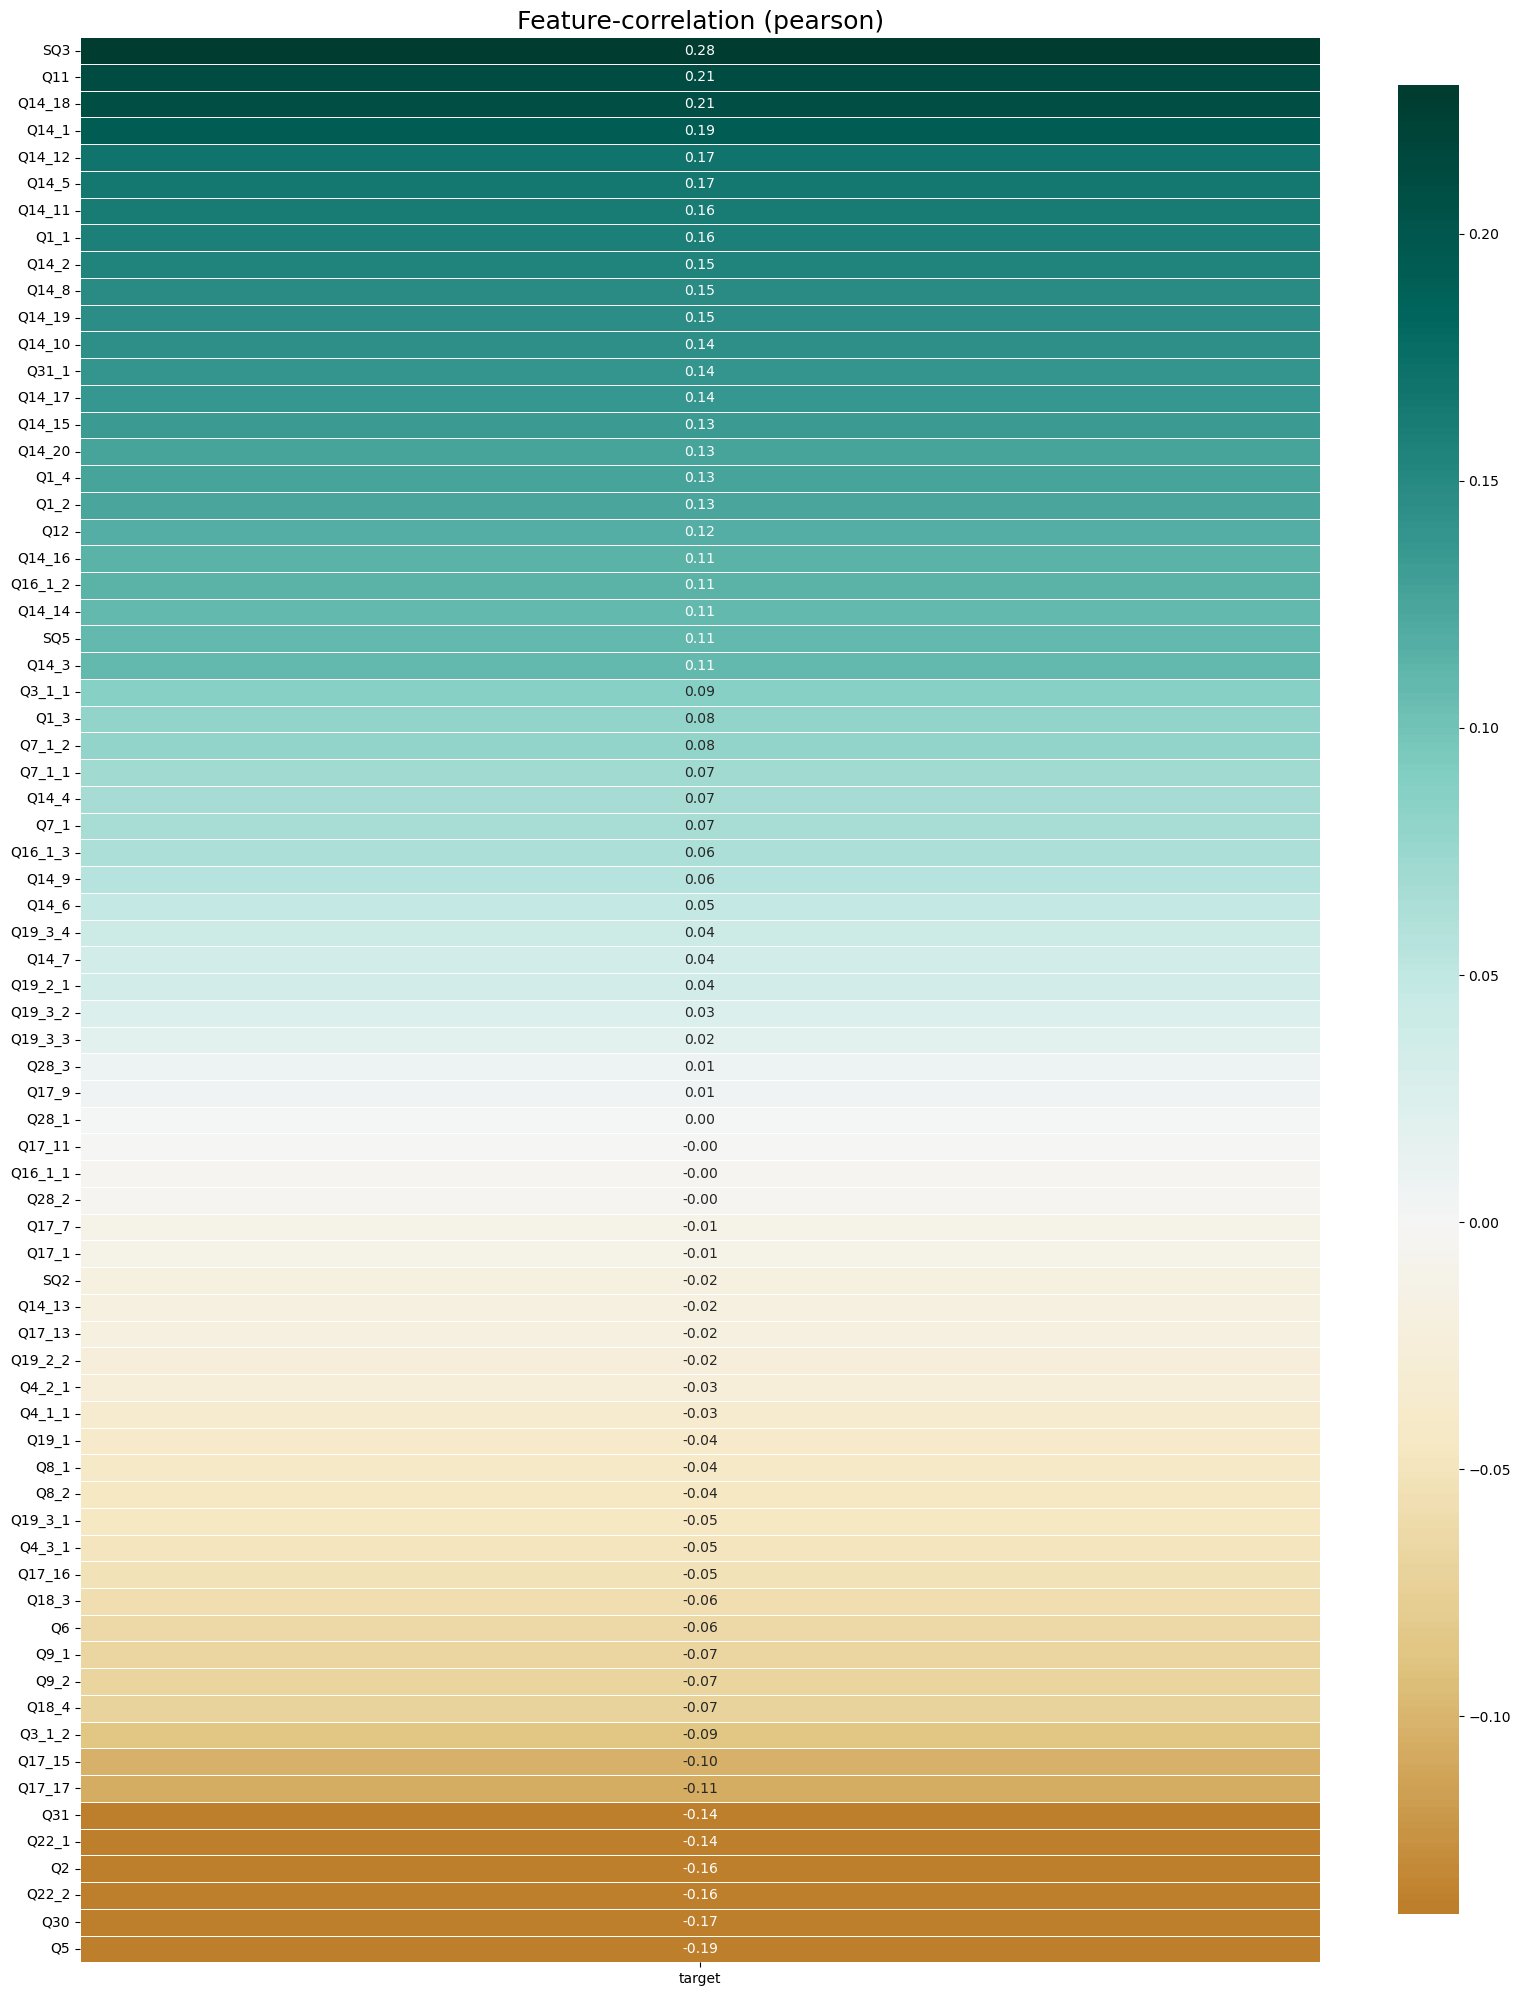

In [8]:
klib.corr_plot(data, target='target', figsize=(20, 25))
plt.show()

#### Feature Importance - SHAP

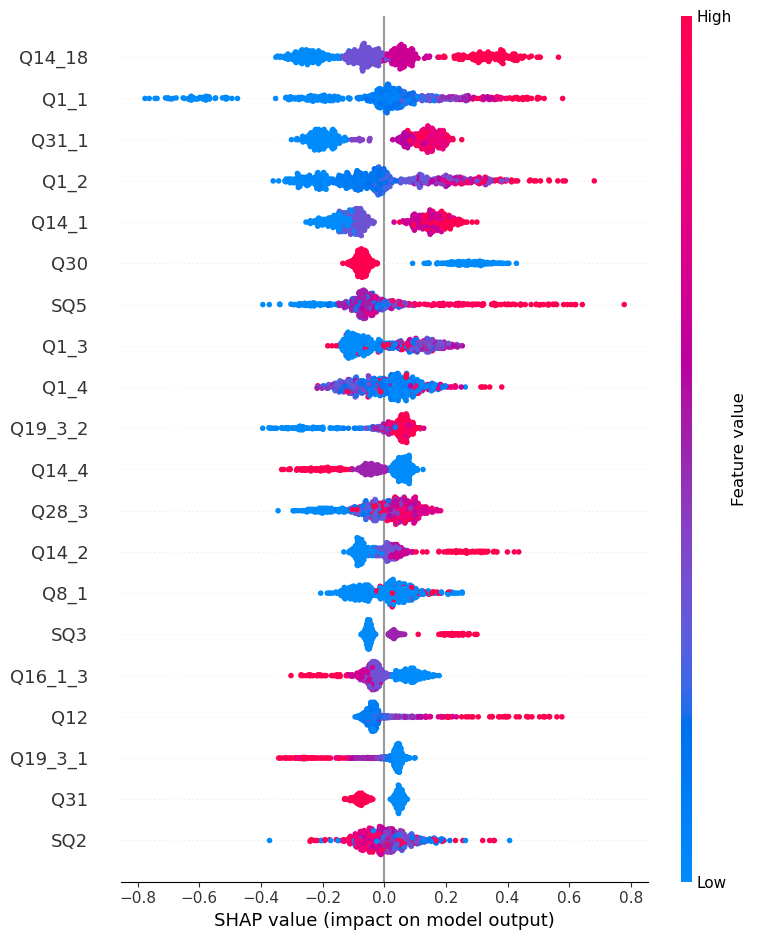

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X_train, y_train)

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)

# SHAP 값 계산
shap_values = explainer.shap_values(X_test)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

#### Feature Importance - Model

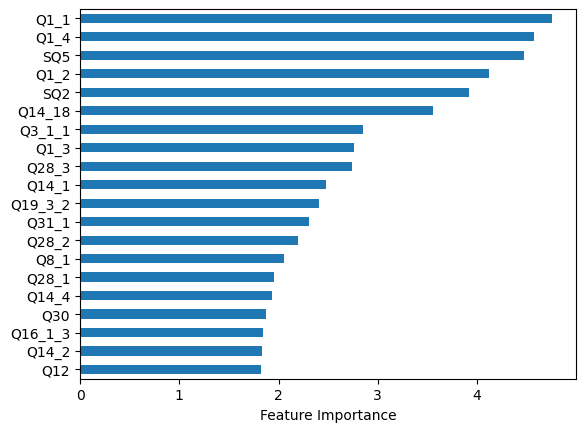

In [11]:
feature_import = pd.Series(model.feature_importances_, X.columns)
feature_import.sort_values(ascending=True).tail(20).plot(kind='barh')
plt.xlabel('Feature Importance')
plt.show()

### <font color = 'navy'> Feature Engineering

In [4]:
data['underprivileged_ratio'] = (data['Q1_2'] * data['Q1_3'] * data['Q1_4']) / data['Q1_1']

In [5]:
data['Q14'] = data.loc[:, 'Q14_1':'Q14_20'].sum(axis=1)

In [6]:
data['supervise'] = data['Q7_1_1'] + data['Q8_1'] + data['Q8_2'] + data['Q12']

### <font color = 'navy'> Modeling

In [7]:
y = data['target']
X = data.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

#### CatBoost

In [19]:
def cat_objective(trial: Trial):
    params_cat = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 0, 100),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait': trial.suggest_int('od_wait', 10, 50)
    }
    
    model = CatBoostClassifier(**params_cat, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5)
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [20]:
cat_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
cat_study.optimize(cat_objective, n_trials = 200)

[I 2023-07-18 15:48:54,765] A new study created in memory with name: no-name-43597a42-1b1c-495b-88a2-62bb43577d27
[I 2023-07-18 15:49:00,256] Trial 0 finished with value: 0.712057526605862 and parameters: {'iterations': 250, 'depth': 10, 'learning_rate': 0.22227824312530747, 'random_strength': 60, 'bagging_temperature': 15, 'od_type': 'IncToDec', 'od_wait': 45}. Best is trial 0 with value: 0.712057526605862.
[I 2023-07-18 15:49:02,551] Trial 1 finished with value: 0.7309179198458173 and parameters: {'iterations': 341, 'depth': 8, 'learning_rate': 0.01596950334578271, 'random_strength': 97, 'bagging_temperature': 84, 'od_type': 'IncToDec', 'od_wait': 17}. Best is trial 1 with value: 0.7309179198458173.
[I 2023-07-18 15:49:04,200] Trial 2 finished with value: 0.7066355600911414 and parameters: {'iterations': 222, 'depth': 7, 'learning_rate': 0.13526405540621358, 'random_strength': 29, 'bagging_temperature': 61, 'od_type': 'Iter', 'od_wait': 25}. Best is trial 1 with value: 0.730917919845

[I 2023-07-18 15:49:32,163] Trial 28 finished with value: 0.7366471701604336 and parameters: {'iterations': 346, 'depth': 4, 'learning_rate': 0.034640351076385606, 'random_strength': 56, 'bagging_temperature': 55, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 18 with value: 0.7373791352651955.
[I 2023-07-18 15:49:32,814] Trial 29 finished with value: 0.7333045754252805 and parameters: {'iterations': 357, 'depth': 4, 'learning_rate': 0.08425872091402678, 'random_strength': 60, 'bagging_temperature': 55, 'od_type': 'IncToDec', 'od_wait': 28}. Best is trial 18 with value: 0.7373791352651955.
[I 2023-07-18 15:49:33,510] Trial 30 finished with value: 0.7208856695561342 and parameters: {'iterations': 388, 'depth': 4, 'learning_rate': 0.11707006506560638, 'random_strength': 67, 'bagging_temperature': 52, 'od_type': 'IncToDec', 'od_wait': 40}. Best is trial 18 with value: 0.7373791352651955.
[I 2023-07-18 15:49:34,095] Trial 31 finished with value: 0.7323229201979424 and parameters: {'i

[I 2023-07-18 15:49:59,820] Trial 56 finished with value: 0.7395657995056251 and parameters: {'iterations': 480, 'depth': 4, 'learning_rate': 0.027457449990665194, 'random_strength': 1, 'bagging_temperature': 22, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:00,759] Trial 57 finished with value: 0.7346205751610771 and parameters: {'iterations': 466, 'depth': 5, 'learning_rate': 0.01161842378461493, 'random_strength': 19, 'bagging_temperature': 34, 'od_type': 'Iter', 'od_wait': 45}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:01,538] Trial 58 finished with value: 0.7323627965123425 and parameters: {'iterations': 435, 'depth': 4, 'learning_rate': 0.06190508580833127, 'random_strength': 13, 'bagging_temperature': 48, 'od_type': 'Iter', 'od_wait': 39}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:02,714] Trial 59 finished with value: 0.7276331045467594 and parameters: {'iterations': 4

[I 2023-07-18 15:50:23,981] Trial 84 finished with value: 0.7368243443728579 and parameters: {'iterations': 404, 'depth': 4, 'learning_rate': 0.056581642924837354, 'random_strength': 19, 'bagging_temperature': 40, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:24,760] Trial 85 finished with value: 0.7396839018441297 and parameters: {'iterations': 443, 'depth': 4, 'learning_rate': 0.03150712431948277, 'random_strength': 12, 'bagging_temperature': 26, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:25,426] Trial 86 finished with value: 0.7275403890465311 and parameters: {'iterations': 368, 'depth': 4, 'learning_rate': 0.0116473581027582, 'random_strength': 14, 'bagging_temperature': 24, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:26,156] Trial 87 finished with value: 0.7393418942758447 and parameters: {'iterations': 4

[I 2023-07-18 15:50:50,989] Trial 112 finished with value: 0.7440024740619364 and parameters: {'iterations': 405, 'depth': 4, 'learning_rate': 0.029553351189735465, 'random_strength': 2, 'bagging_temperature': 2, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:51,766] Trial 113 finished with value: 0.7416932274012565 and parameters: {'iterations': 442, 'depth': 4, 'learning_rate': 0.034633523705053924, 'random_strength': 2, 'bagging_temperature': 35, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:52,509] Trial 114 finished with value: 0.7420286263896732 and parameters: {'iterations': 420, 'depth': 4, 'learning_rate': 0.030069069704363044, 'random_strength': 7, 'bagging_temperature': 29, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:50:53,207] Trial 115 finished with value: 0.7350888094626745 and parameters: {'iterations'

[I 2023-07-18 15:51:10,621] Trial 140 finished with value: 0.7292498850672253 and parameters: {'iterations': 387, 'depth': 4, 'learning_rate': 0.06906599805013922, 'random_strength': 7, 'bagging_temperature': 27, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:51:11,335] Trial 141 finished with value: 0.7395864505157721 and parameters: {'iterations': 407, 'depth': 4, 'learning_rate': 0.03757550897533001, 'random_strength': 15, 'bagging_temperature': 39, 'od_type': 'Iter', 'od_wait': 48}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:51:12,066] Trial 142 finished with value: 0.73811917810636 and parameters: {'iterations': 416, 'depth': 4, 'learning_rate': 0.044128857837917604, 'random_strength': 22, 'bagging_temperature': 44, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 46 with value: 0.7455924268742499.
[I 2023-07-18 15:51:12,776] Trial 143 finished with value: 0.7379996672672477 and parameters: {'iterations':

[I 2023-07-18 15:51:32,986] Trial 168 finished with value: 0.7430309798687936 and parameters: {'iterations': 374, 'depth': 4, 'learning_rate': 0.021830902648495302, 'random_strength': 1, 'bagging_temperature': 34, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 151 with value: 0.7474877901514898.
[I 2023-07-18 15:51:33,695] Trial 169 finished with value: 0.7400047419520448 and parameters: {'iterations': 379, 'depth': 4, 'learning_rate': 0.018733451759107546, 'random_strength': 1, 'bagging_temperature': 35, 'od_type': 'Iter', 'od_wait': 50}. Best is trial 151 with value: 0.7474877901514898.
[I 2023-07-18 15:51:34,347] Trial 170 finished with value: 0.7394266708484262 and parameters: {'iterations': 352, 'depth': 4, 'learning_rate': 0.023821786405388335, 'random_strength': 0, 'bagging_temperature': 33, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 151 with value: 0.7474877901514898.
[I 2023-07-18 15:51:35,017] Trial 171 finished with value: 0.7411145398234592 and parameters: {'ite

[I 2023-07-18 15:51:52,702] Trial 196 finished with value: 0.7348148269330396 and parameters: {'iterations': 434, 'depth': 4, 'learning_rate': 0.030306789659448313, 'random_strength': 0, 'bagging_temperature': 39, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 151 with value: 0.7474877901514898.
[I 2023-07-18 15:51:53,446] Trial 197 finished with value: 0.7357789423910128 and parameters: {'iterations': 413, 'depth': 4, 'learning_rate': 0.05590611848281453, 'random_strength': 11, 'bagging_temperature': 22, 'od_type': 'Iter', 'od_wait': 49}. Best is trial 151 with value: 0.7474877901514898.
[I 2023-07-18 15:51:54,109] Trial 198 finished with value: 0.732149898583582 and parameters: {'iterations': 356, 'depth': 4, 'learning_rate': 0.01573075432557408, 'random_strength': 9, 'bagging_temperature': 46, 'od_type': 'Iter', 'od_wait': 46}. Best is trial 151 with value: 0.7474877901514898.
[I 2023-07-18 15:51:54,809] Trial 199 finished with value: 0.741289202647223 and parameters: {'iterations

In [21]:
CAT = CatBoostClassifier(**cat_study.best_params, random_state=42, verbose=False)
CAT.fit(X_train, y_train)
cat_pred = CAT.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, cat_pred)

In [22]:
score

0.7279430460208491

#### LGBM

In [12]:
def lgb_objective(trial: Trial):
    
    params_lgb = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000) ,
        'max_depth': trial.suggest_int('max_depth', 6, 20), 
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.1), 
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, step=1), 
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100), 
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
    }
    
    model = LGBMClassifier(random_state=42, **params_lgb)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5)
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [13]:
lgb_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
lgb_study.optimize(lgb_objective, n_trials = 200)

[I 2023-07-18 14:30:56,776] A new study created in memory with name: no-name-f2b9f50c-68eb-4d30-bedd-36cbdbb3360d
[I 2023-07-18 14:30:59,317] Trial 0 finished with value: 0.7167718810788065 and parameters: {'num_leaves': 381, 'max_depth': 20, 'learning_rate': 0.07322619478695937, 'n_estimators': 2398, 'class_weight': 'balanced', 'min_child_samples': 15, 'subsample': 0.9598528437324805, 'colsample_bytree': 0.8803345035229626, 'reg_alpha': 0.7080725777960455, 'reg_lambda': 0.020584494295802447}. Best is trial 0 with value: 0.7167718810788065.
[I 2023-07-18 14:31:01,563] Trial 1 finished with value: 0.712162151080791 and parameters: {'num_leaves': 971, 'max_depth': 18, 'learning_rate': 0.021312677156759788, 'n_estimators': 1772, 'class_weight': None, 'min_child_samples': 57, 'subsample': 0.8295835055926347, 'colsample_bytree': 0.7873687420594125, 'reg_alpha': 0.6118528947223795, 'reg_lambda': 0.13949386065204183}. Best is trial 0 with value: 0.7167718810788065.
[I 2023-07-18 14:31:03,588]

[I 2023-07-18 14:31:34,639] Trial 19 finished with value: 0.7136900657110734 and parameters: {'num_leaves': 794, 'max_depth': 14, 'learning_rate': 0.014811409830712954, 'n_estimators': 2645, 'class_weight': 'balanced', 'min_child_samples': 42, 'subsample': 0.9753119917467995, 'colsample_bytree': 0.7293020872941902, 'reg_alpha': 0.7777511721393076, 'reg_lambda': 0.7341744061108378}. Best is trial 16 with value: 0.7382948525426718.
[I 2023-07-18 14:31:35,834] Trial 20 finished with value: 0.7160732289089063 and parameters: {'num_leaves': 582, 'max_depth': 18, 'learning_rate': 0.029975225396168523, 'n_estimators': 2291, 'class_weight': 'balanced', 'min_child_samples': 26, 'subsample': 0.928111200636984, 'colsample_bytree': 0.8131668742926736, 'reg_alpha': 0.6548865139930261, 'reg_lambda': 0.869555108333001}. Best is trial 16 with value: 0.7382948525426718.
[I 2023-07-18 14:31:37,918] Trial 21 finished with value: 0.7387511145891065 and parameters: {'num_leaves': 724, 'max_depth': 14, 'lea

[I 2023-07-18 14:32:08,586] Trial 38 finished with value: 0.719994826749322 and parameters: {'num_leaves': 816, 'max_depth': 17, 'learning_rate': 0.008106190904168723, 'n_estimators': 2531, 'class_weight': None, 'min_child_samples': 58, 'subsample': 0.9561116354206918, 'colsample_bytree': 0.7384336107335074, 'reg_alpha': 0.7574033275164269, 'reg_lambda': 0.9141525227722966}. Best is trial 21 with value: 0.7387511145891065.
[I 2023-07-18 14:32:10,506] Trial 39 finished with value: 0.7136682272445135 and parameters: {'num_leaves': 926, 'max_depth': 10, 'learning_rate': 0.012205836245151659, 'n_estimators': 2187, 'class_weight': 'balanced', 'min_child_samples': 37, 'subsample': 0.8875599001132035, 'colsample_bytree': 0.7590972298770565, 'reg_alpha': 0.6794228114860211, 'reg_lambda': 0.8062777260602865}. Best is trial 21 with value: 0.7387511145891065.
[I 2023-07-18 14:32:12,308] Trial 40 finished with value: 0.728998044283784 and parameters: {'num_leaves': 622, 'max_depth': 13, 'learning_

[I 2023-07-18 14:32:44,338] Trial 57 finished with value: 0.7292548638106765 and parameters: {'num_leaves': 792, 'max_depth': 14, 'learning_rate': 0.003402050245990708, 'n_estimators': 2356, 'class_weight': 'balanced', 'min_child_samples': 53, 'subsample': 0.9211888461427296, 'colsample_bytree': 0.7230122343142937, 'reg_alpha': 0.8526646019522378, 'reg_lambda': 0.9129298170521593}. Best is trial 41 with value: 0.739686956219981.
[I 2023-07-18 14:32:45,181] Trial 58 finished with value: 0.7091113291419505 and parameters: {'num_leaves': 737, 'max_depth': 16, 'learning_rate': 0.05511127317312932, 'n_estimators': 2842, 'class_weight': 'balanced', 'min_child_samples': 42, 'subsample': 0.9058594609520947, 'colsample_bytree': 0.7110656067026343, 'reg_alpha': 0.996242764916816, 'reg_lambda': 0.7973787479691217}. Best is trial 41 with value: 0.739686956219981.
[I 2023-07-18 14:32:47,311] Trial 59 finished with value: 0.713881958609037 and parameters: {'num_leaves': 848, 'max_depth': 12, 'learni

[I 2023-07-18 14:33:20,236] Trial 76 finished with value: 0.7059177826409445 and parameters: {'num_leaves': 729, 'max_depth': 19, 'learning_rate': 0.0180110901636761, 'n_estimators': 2622, 'class_weight': 'balanced', 'min_child_samples': 73, 'subsample': 0.8995987698610928, 'colsample_bytree': 0.7278478360517829, 'reg_alpha': 0.9371135529526349, 'reg_lambda': 0.8997329846000249}. Best is trial 41 with value: 0.739686956219981.
[I 2023-07-18 14:33:22,869] Trial 77 finished with value: 0.7328439134912342 and parameters: {'num_leaves': 660, 'max_depth': 17, 'learning_rate': 0.0027780507793822256, 'n_estimators': 2697, 'class_weight': 'balanced', 'min_child_samples': 32, 'subsample': 0.9207757545747421, 'colsample_bytree': 0.7509161513858986, 'reg_alpha': 0.970942445225286, 'reg_lambda': 0.94611048985588}. Best is trial 41 with value: 0.739686956219981.
[I 2023-07-18 14:33:25,160] Trial 78 finished with value: 0.7170767538056125 and parameters: {'num_leaves': 665, 'max_depth': 18, 'learnin

[I 2023-07-18 14:33:52,501] Trial 95 finished with value: 0.7428894191422232 and parameters: {'num_leaves': 1000, 'max_depth': 20, 'learning_rate': 0.0020842972788140714, 'n_estimators': 2393, 'class_weight': 'balanced', 'min_child_samples': 100, 'subsample': 0.8775279521520382, 'colsample_bytree': 0.7281008683177267, 'reg_alpha': 0.8692117390326841, 'reg_lambda': 0.9792397727923514}. Best is trial 95 with value: 0.7428894191422232.
[I 2023-07-18 14:33:53,965] Trial 96 finished with value: 0.7404399435608265 and parameters: {'num_leaves': 1000, 'max_depth': 20, 'learning_rate': 0.0023477837905752485, 'n_estimators': 2379, 'class_weight': 'balanced', 'min_child_samples': 93, 'subsample': 0.8763624954806575, 'colsample_bytree': 0.7307110091778999, 'reg_alpha': 0.883401691211703, 'reg_lambda': 0.9745590250161127}. Best is trial 95 with value: 0.7428894191422232.
[I 2023-07-18 14:33:55,027] Trial 97 finished with value: 0.7220377796023157 and parameters: {'num_leaves': 993, 'max_depth': 20

[I 2023-07-18 14:34:18,340] Trial 114 finished with value: 0.7415398192307576 and parameters: {'num_leaves': 913, 'max_depth': 19, 'learning_rate': 0.0024436237238552234, 'n_estimators': 2266, 'class_weight': None, 'min_child_samples': 98, 'subsample': 0.8558389691856365, 'colsample_bytree': 0.7066147649582596, 'reg_alpha': 0.864902509304082, 'reg_lambda': 0.8327155365698808}. Best is trial 109 with value: 0.7440203229432354.
[I 2023-07-18 14:34:19,686] Trial 115 finished with value: 0.7287082533032327 and parameters: {'num_leaves': 910, 'max_depth': 20, 'learning_rate': 0.0051758061138282695, 'n_estimators': 2271, 'class_weight': None, 'min_child_samples': 99, 'subsample': 0.8621544205861547, 'colsample_bytree': 0.7206202440044683, 'reg_alpha': 0.7923247363599241, 'reg_lambda': 0.8416074251298017}. Best is trial 109 with value: 0.7440203229432354.
[I 2023-07-18 14:34:21,065] Trial 116 finished with value: 0.7192972981721424 and parameters: {'num_leaves': 882, 'max_depth': 20, 'learnin

[I 2023-07-18 14:34:43,059] Trial 134 finished with value: 0.7310136506454825 and parameters: {'num_leaves': 870, 'max_depth': 20, 'learning_rate': 0.007062593159390906, 'n_estimators': 1613, 'class_weight': None, 'min_child_samples': 92, 'subsample': 0.8673378145789353, 'colsample_bytree': 0.7002902289770175, 'reg_alpha': 0.8558284191517656, 'reg_lambda': 0.8703946327949204}. Best is trial 122 with value: 0.7443638358283187.
[I 2023-07-18 14:34:44,095] Trial 135 finished with value: 0.7428226987892289 and parameters: {'num_leaves': 908, 'max_depth': 18, 'learning_rate': 0.001798895734696868, 'n_estimators': 1669, 'class_weight': None, 'min_child_samples': 96, 'subsample': 0.8743740139538203, 'colsample_bytree': 0.714557812993688, 'reg_alpha': 0.8897140515896417, 'reg_lambda': 0.7603316014346073}. Best is trial 122 with value: 0.7443638358283187.
[I 2023-07-18 14:34:45,065] Trial 136 finished with value: 0.7105544931533895 and parameters: {'num_leaves': 908, 'max_depth': 18, 'learning_

[I 2023-07-18 14:35:05,219] Trial 154 finished with value: 0.7262808631863287 and parameters: {'num_leaves': 860, 'max_depth': 19, 'learning_rate': 0.006550049132627266, 'n_estimators': 1880, 'class_weight': None, 'min_child_samples': 81, 'subsample': 0.8974231445733536, 'colsample_bytree': 0.7237898857718968, 'reg_alpha': 0.76626943883234, 'reg_lambda': 0.8935048474168769}. Best is trial 122 with value: 0.7443638358283187.
[I 2023-07-18 14:35:06,406] Trial 155 finished with value: 0.7424353757029563 and parameters: {'num_leaves': 972, 'max_depth': 19, 'learning_rate': 0.002375936268880598, 'n_estimators': 1911, 'class_weight': None, 'min_child_samples': 86, 'subsample': 0.8608807779705279, 'colsample_bytree': 0.7173322547911278, 'reg_alpha': 0.8005509105953961, 'reg_lambda': 0.8075658983680272}. Best is trial 122 with value: 0.7443638358283187.
[I 2023-07-18 14:35:07,755] Trial 156 finished with value: 0.7312817381772339 and parameters: {'num_leaves': 972, 'max_depth': 18, 'learning_r

[I 2023-07-18 14:35:29,886] Trial 174 finished with value: 0.7296013704156841 and parameters: {'num_leaves': 953, 'max_depth': 18, 'learning_rate': 0.004729821163299325, 'n_estimators': 2043, 'class_weight': None, 'min_child_samples': 86, 'subsample': 0.8588159490337612, 'colsample_bytree': 0.8110731761380486, 'reg_alpha': 0.8176212647863887, 'reg_lambda': 0.7896058356077309}. Best is trial 159 with value: 0.7443812294985518.
[I 2023-07-18 14:35:31,084] Trial 175 finished with value: 0.7435097840488618 and parameters: {'num_leaves': 1000, 'max_depth': 18, 'learning_rate': 0.002103792634905309, 'n_estimators': 1909, 'class_weight': None, 'min_child_samples': 91, 'subsample': 0.8350995521167803, 'colsample_bytree': 0.801316895868545, 'reg_alpha': 0.7797577483302676, 'reg_lambda': 0.8134009549369526}. Best is trial 159 with value: 0.7443812294985518.
[I 2023-07-18 14:35:32,330] Trial 176 finished with value: 0.7225987081162442 and parameters: {'num_leaves': 909, 'max_depth': 18, 'learning

[I 2023-07-18 14:35:52,970] Trial 194 finished with value: 0.7442682837886684 and parameters: {'num_leaves': 879, 'max_depth': 18, 'learning_rate': 0.0020201701930646996, 'n_estimators': 1798, 'class_weight': None, 'min_child_samples': 84, 'subsample': 0.861396468892307, 'colsample_bytree': 0.7758374107402534, 'reg_alpha': 0.8459875714220478, 'reg_lambda': 0.8270807575443585}. Best is trial 180 with value: 0.744624557164347.
[I 2023-07-18 14:35:54,139] Trial 195 finished with value: 0.7331615639139228 and parameters: {'num_leaves': 866, 'max_depth': 18, 'learning_rate': 0.004904203396997375, 'n_estimators': 1791, 'class_weight': None, 'min_child_samples': 83, 'subsample': 0.8652260984134176, 'colsample_bytree': 0.7743717428022511, 'reg_alpha': 0.8488106568688796, 'reg_lambda': 0.7904458555164339}. Best is trial 180 with value: 0.744624557164347.
[I 2023-07-18 14:35:55,254] Trial 196 finished with value: 0.740684007262964 and parameters: {'num_leaves': 880, 'max_depth': 18, 'learning_ra

In [14]:
LGBM = LGBMClassifier(**lgb_study.best_params, random_state=42)
LGBM.fit(X_train, y_train)
lgbm_pred = LGBM.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, lgbm_pred)

In [15]:
score

0.7266858773342374

#### RandomForest

In [23]:
def rf_objective(trial: Trial):
    
    params_rf = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'n_estimators':  trial.suggest_int('n_estimators', 100, 1000)
            }
    
    model = RandomForestClassifier(random_state=42, **params_rf)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5)
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [24]:
rf_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
rf_study.optimize(rf_objective, n_trials = 200)

[I 2023-07-18 15:53:57,184] A new study created in memory with name: no-name-ff4bb74c-1e29-4f88-baa9-a580edb80528
[I 2023-07-18 15:53:58,389] Trial 0 finished with value: 0.7376905410435766 and parameters: {'max_depth': 9, 'max_leaf_nodes': 476, 'min_samples_leaf': 15, 'n_estimators': 639}. Best is trial 0 with value: 0.7376905410435766.
[I 2023-07-18 15:53:59,776] Trial 1 finished with value: 0.7341865796720702 and parameters: {'max_depth': 5, 'max_leaf_nodes': 79, 'min_samples_leaf': 2, 'n_estimators': 880}. Best is trial 0 with value: 0.7376905410435766.
[I 2023-07-18 15:54:02,274] Trial 2 finished with value: 0.7302610762315231 and parameters: {'max_depth': 13, 'max_leaf_nodes': 355, 'min_samples_leaf': 1, 'n_estimators': 973}. Best is trial 0 with value: 0.7376905410435766.
[I 2023-07-18 15:54:02,988] Trial 3 finished with value: 0.7348115935055582 and parameters: {'max_depth': 17, 'max_leaf_nodes': 107, 'min_samples_leaf': 4, 'n_estimators': 265}. Best is trial 0 with value: 0.73

[I 2023-07-18 15:54:46,506] Trial 36 finished with value: 0.7375105037547621 and parameters: {'max_depth': 13, 'max_leaf_nodes': 372, 'min_samples_leaf': 15, 'n_estimators': 607}. Best is trial 23 with value: 0.7398089746567582.
[I 2023-07-18 15:54:48,317] Trial 37 finished with value: 0.7357728846719411 and parameters: {'max_depth': 14, 'max_leaf_nodes': 355, 'min_samples_leaf': 4, 'n_estimators': 808}. Best is trial 23 with value: 0.7398089746567582.
[I 2023-07-18 15:54:50,113] Trial 38 finished with value: 0.7381042165054982 and parameters: {'max_depth': 11, 'max_leaf_nodes': 321, 'min_samples_leaf': 6, 'n_estimators': 887}. Best is trial 23 with value: 0.7398089746567582.
[I 2023-07-18 15:54:51,590] Trial 39 finished with value: 0.7374384249755445 and parameters: {'max_depth': 15, 'max_leaf_nodes': 420, 'min_samples_leaf': 8, 'n_estimators': 717}. Best is trial 23 with value: 0.7398089746567582.
[I 2023-07-18 15:54:53,358] Trial 40 finished with value: 0.7382101468325433 and parame

[I 2023-07-18 15:55:32,100] Trial 72 finished with value: 0.7401003342345696 and parameters: {'max_depth': 14, 'max_leaf_nodes': 293, 'min_samples_leaf': 11, 'n_estimators': 749}. Best is trial 52 with value: 0.7402147622236638.
[I 2023-07-18 15:55:33,516] Trial 73 finished with value: 0.7384724796332416 and parameters: {'max_depth': 13, 'max_leaf_nodes': 291, 'min_samples_leaf': 13, 'n_estimators': 748}. Best is trial 52 with value: 0.7402147622236638.
[I 2023-07-18 15:55:35,154] Trial 74 finished with value: 0.7381316784763465 and parameters: {'max_depth': 15, 'max_leaf_nodes': 289, 'min_samples_leaf': 10, 'n_estimators': 819}. Best is trial 52 with value: 0.7402147622236638.
[I 2023-07-18 15:55:36,648] Trial 75 finished with value: 0.7383245602408856 and parameters: {'max_depth': 16, 'max_leaf_nodes': 330, 'min_samples_leaf': 12, 'n_estimators': 764}. Best is trial 52 with value: 0.7402147622236638.
[I 2023-07-18 15:55:38,062] Trial 76 finished with value: 0.7403789913531769 and par

[I 2023-07-18 15:56:20,610] Trial 108 finished with value: 0.7377419982657654 and parameters: {'max_depth': 13, 'max_leaf_nodes': 301, 'min_samples_leaf': 10, 'n_estimators': 531}. Best is trial 76 with value: 0.7403789913531769.
[I 2023-07-18 15:56:21,819] Trial 109 finished with value: 0.7405290453675711 and parameters: {'max_depth': 12, 'max_leaf_nodes': 258, 'min_samples_leaf': 11, 'n_estimators': 611}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:56:22,916] Trial 110 finished with value: 0.7377897053186354 and parameters: {'max_depth': 11, 'max_leaf_nodes': 266, 'min_samples_leaf': 13, 'n_estimators': 569}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:56:24,140] Trial 111 finished with value: 0.7405117476386837 and parameters: {'max_depth': 12, 'max_leaf_nodes': 258, 'min_samples_leaf': 11, 'n_estimators': 616}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:56:25,394] Trial 112 finished with value: 0.7383120648283545

[I 2023-07-18 15:57:03,052] Trial 144 finished with value: 0.7381825813383583 and parameters: {'max_depth': 13, 'max_leaf_nodes': 346, 'min_samples_leaf': 12, 'n_estimators': 616}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:04,194] Trial 145 finished with value: 0.7402059038338191 and parameters: {'max_depth': 13, 'max_leaf_nodes': 372, 'min_samples_leaf': 11, 'n_estimators': 574}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:05,448] Trial 146 finished with value: 0.7401491386348071 and parameters: {'max_depth': 12, 'max_leaf_nodes': 338, 'min_samples_leaf': 11, 'n_estimators': 639}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:06,783] Trial 147 finished with value: 0.7377946321546107 and parameters: {'max_depth': 14, 'max_leaf_nodes': 354, 'min_samples_leaf': 10, 'n_estimators': 663}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:07,563] Trial 148 finished with value: 0.726612803037228

[I 2023-07-18 15:57:46,578] Trial 180 finished with value: 0.7220256662054774 and parameters: {'max_depth': 14, 'max_leaf_nodes': 5, 'min_samples_leaf': 12, 'n_estimators': 624}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:47,976] Trial 181 finished with value: 0.7403080647449528 and parameters: {'max_depth': 14, 'max_leaf_nodes': 242, 'min_samples_leaf': 11, 'n_estimators': 712}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:49,391] Trial 182 finished with value: 0.7403257243680958 and parameters: {'max_depth': 14, 'max_leaf_nodes': 244, 'min_samples_leaf': 11, 'n_estimators': 719}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:50,823] Trial 183 finished with value: 0.7401182551447818 and parameters: {'max_depth': 15, 'max_leaf_nodes': 378, 'min_samples_leaf': 11, 'n_estimators': 734}. Best is trial 109 with value: 0.7405290453675711.
[I 2023-07-18 15:57:52,145] Trial 184 finished with value: 0.7402556367363203 

In [25]:
RF = RandomForestClassifier(**rf_study.best_params, random_state=42)
RF.fit(X_train, y_train)
rf_pred = RF.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, rf_pred)

In [26]:
score

0.7350057914512529

#### ExtraTrees

In [27]:
def et_objective(trial):
    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth': trial.suggest_int('max_depth', 10, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
        
    model = ExtraTreesClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, scoring = 'roc_auc', n_jobs = -1, cv=5) ## 평가지표 변경 필요
    # score = np.mean(scores)
    score = sum(scores) / len(scores)
    
    return score

In [28]:
et_study = optuna.create_study(sampler = optuna.samplers.TPESampler(seed=42), direction = 'maximize')
et_study.optimize(et_objective, n_trials = 200)

[I 2023-07-18 15:59:07,250] A new study created in memory with name: no-name-78e8506d-faf6-4210-a5d0-9bc483def2b9
[I 2023-07-18 15:59:07,503] Trial 0 finished with value: 0.7279963997208078 and parameters: {'n_estimators': 81, 'criterion': 'gini', 'max_depth': 124, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.7279963997208078.
[I 2023-07-18 15:59:07,817] Trial 1 finished with value: 0.7347316545347522 and parameters: {'n_estimators': 124, 'criterion': 'gini', 'max_depth': 195, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.7347316545347522.
[I 2023-07-18 15:59:08,038] Trial 2 finished with value: 0.7311896613139269 and parameters: {'n_estimators': 68, 'criterion': 'gini', 'max_depth': 65, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.7347316545347522.
[I 2023-07-18 15:59:08,336] Trial 3 finished with value: 0.72577117507

[I 2023-07-18 15:59:16,631] Trial 30 finished with value: 0.7332756206770805 and parameters: {'n_estimators': 190, 'criterion': 'entropy', 'max_depth': 140, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 12 with value: 0.7368894246829087.
[I 2023-07-18 15:59:16,995] Trial 31 finished with value: 0.7365474681472545 and parameters: {'n_estimators': 174, 'criterion': 'entropy', 'max_depth': 125, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 12 with value: 0.7368894246829087.
[I 2023-07-18 15:59:17,358] Trial 32 finished with value: 0.7362416225926998 and parameters: {'n_estimators': 171, 'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 12 with value: 0.7368894246829087.
[I 2023-07-18 15:59:17,658] Trial 33 finished with value: 0.7334328183849281 and parameters: {'n_estimators': 129, 'criterion': 'entropy', 'max_depth': 55, 'min_sampl

[I 2023-07-18 15:59:24,634] Trial 60 finished with value: 0.7380351565250978 and parameters: {'n_estimators': 111, 'criterion': 'entropy', 'max_depth': 191, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 39 with value: 0.7394188269872799.
[I 2023-07-18 15:59:24,921] Trial 61 finished with value: 0.7377402934842849 and parameters: {'n_estimators': 113, 'criterion': 'entropy', 'max_depth': 189, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 39 with value: 0.7394188269872799.
[I 2023-07-18 15:59:25,220] Trial 62 finished with value: 0.7377402934842849 and parameters: {'n_estimators': 113, 'criterion': 'entropy', 'max_depth': 194, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 39 with value: 0.7394188269872799.
[I 2023-07-18 15:59:25,519] Trial 63 finished with value: 0.7362207910728473 and parameters: {'n_estimators': 110, 'criterion': 'entropy', 'max_depth': 194, 'min_samp

[I 2023-07-18 15:59:31,876] Trial 90 finished with value: 0.7284983450117863 and parameters: {'n_estimators': 35, 'criterion': 'entropy', 'max_depth': 167, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 82 with value: 0.7396416998998447.
[I 2023-07-18 15:59:32,126] Trial 91 finished with value: 0.7386859727482836 and parameters: {'n_estimators': 69, 'criterion': 'entropy', 'max_depth': 165, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 82 with value: 0.7396416998998447.
[I 2023-07-18 15:59:32,362] Trial 92 finished with value: 0.7398741103736654 and parameters: {'n_estimators': 61, 'criterion': 'entropy', 'max_depth': 164, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:32,598] Trial 93 finished with value: 0.7397641061846153 and parameters: {'n_estimators': 59, 'criterion': 'entropy', 'max_depth': 155, 'min_samples_

[I 2023-07-18 15:59:38,733] Trial 120 finished with value: 0.7384148996618286 and parameters: {'n_estimators': 45, 'criterion': 'entropy', 'max_depth': 140, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:38,951] Trial 121 finished with value: 0.7377843124818378 and parameters: {'n_estimators': 50, 'criterion': 'entropy', 'max_depth': 134, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:39,172] Trial 122 finished with value: 0.7394188269872799 and parameters: {'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 135, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:39,392] Trial 123 finished with value: 0.7385581365916064 and parameters: {'n_estimators': 55, 'criterion': 'entropy', 'max_depth': 106, 'min_samp

[I 2023-07-18 15:59:45,843] Trial 150 finished with value: 0.7299055351011912 and parameters: {'n_estimators': 58, 'criterion': 'entropy', 'max_depth': 122, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:46,078] Trial 151 finished with value: 0.7396896994425924 and parameters: {'n_estimators': 64, 'criterion': 'entropy', 'max_depth': 139, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:46,299] Trial 152 finished with value: 0.7394963729651286 and parameters: {'n_estimators': 62, 'criterion': 'entropy', 'max_depth': 125, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 92 with value: 0.7398741103736654.
[I 2023-07-18 15:59:46,534] Trial 153 finished with value: 0.739032190946024 and parameters: {'n_estimators': 67, 'criterion': 'entropy', 'max_depth': 130, 'min_sampl

[I 2023-07-18 15:59:52,670] Trial 180 finished with value: 0.7319135559726624 and parameters: {'n_estimators': 43, 'criterion': 'entropy', 'max_depth': 144, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 176 with value: 0.7411545438652435.
[I 2023-07-18 15:59:52,906] Trial 181 finished with value: 0.7394188269872799 and parameters: {'n_estimators': 60, 'criterion': 'entropy', 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 176 with value: 0.7411545438652435.
[I 2023-07-18 15:59:53,144] Trial 182 finished with value: 0.7383833988227793 and parameters: {'n_estimators': 71, 'criterion': 'entropy', 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 176 with value: 0.7411545438652435.
[I 2023-07-18 15:59:53,363] Trial 183 finished with value: 0.7389977929116259 and parameters: {'n_estimators': 54, 'criterion': 'entropy', 'max_depth': 36, 'min_samp

In [29]:
ET = ExtraTreesClassifier(**et_study.best_params)
ET.fit(X_train, y_train)
et_pred = ET.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, et_pred)

In [30]:
score

0.7150747238466536

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

# XGB = XGBClassifier(random_state=42)
# XGB.fit(X_train, y_train)
# xgb_pred = XGB.predict_proba(X_test)[:, 1]
# score = roc_auc_score(y_test, xgb_pred)

In [29]:
# score

0.6940701189366331

### <font color = 'navy'> Ensemble`

In [31]:
clfs = [CAT, LGBM, ET, RF]

CatBoostClassifier             0.7279430460208491
LGBMClassifier                 0.7266858773342374
ExtraTreesClassifier           0.7035200723225132
RandomForestClassifier         0.7350057914512529


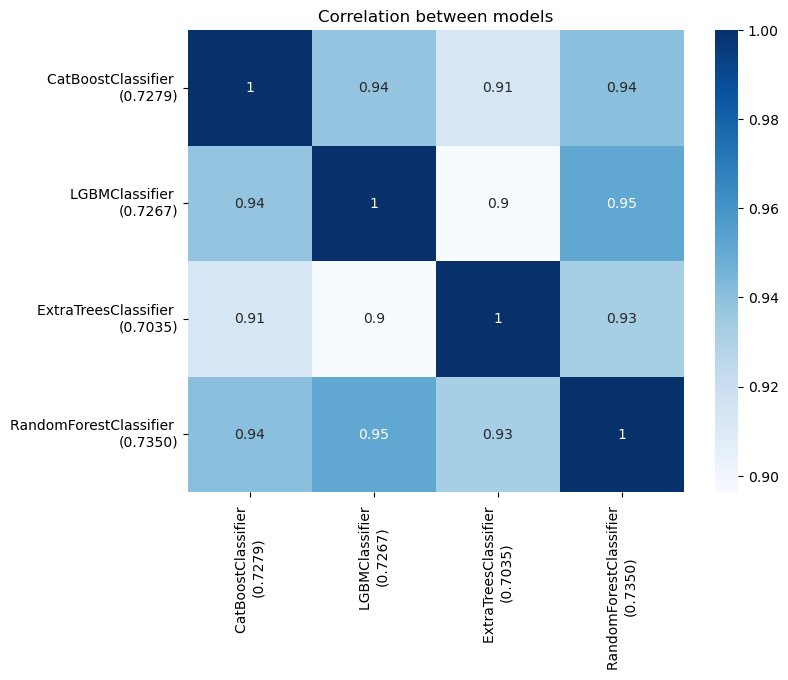

In [32]:
pred_results = []
for clf in clfs :
    pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    name = type(clf).__name__
    score = roc_auc_score(y_test, pred)
    pred_results.append(pd.Series(pred, name=f'{name} \n({score:.4f})'))
    print("{:30s} {}".format(name, score))

ensemble_results = pd.concat(pred_results, axis=1)
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(),annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

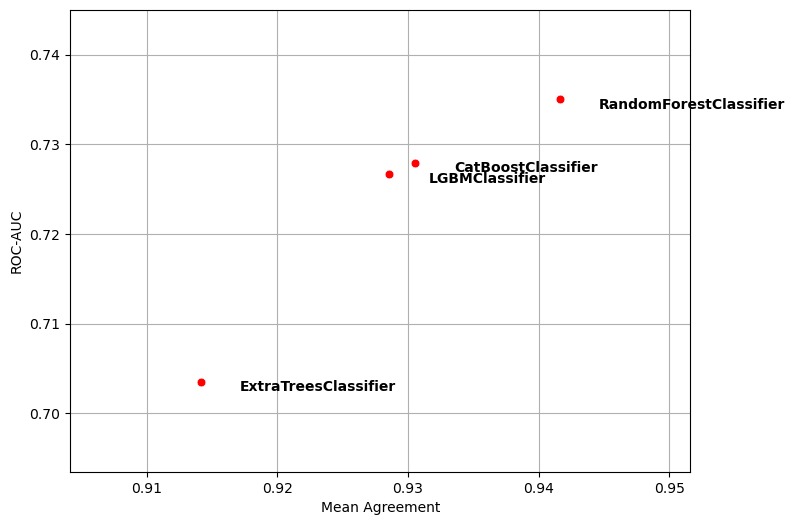

In [33]:
corr = (ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)
names = corr.index.str[:-10]
aucs = np.array(corr.index.str[-7:-1]).astype(float)
df = pd.DataFrame({'model': names, 'auc': aucs, 'cor': corr})        

plt.figure(figsize=(8,6))
g = sns.scatterplot(x="cor", y="auc", data=df, s=40, color='red')
for line in range(0, df.shape[0]):
     g.text(df.cor[line]+0.003, df.auc[line]-0.001, 
            df.model[line], horizontalalignment='left', 
            size='medium', color='black', weight='semibold')
        
plt.xlim((df.cor.min()-0.01,df.cor.max()+0.01))
plt.ylim((df.auc.min()-0.01,df.auc.max()+0.01))
plt.xlabel('Mean Agreement')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

### <font color = 'navy'> Predict

In [16]:
# ensemble_pred = cat_pred*0.9 + lgbm_pred*0.1

In [72]:
ensemble_pred = rf_pred*0.7 + cat_pred*0.3

In [73]:
score = roc_auc_score(y_test, ensemble_pred)

In [74]:
score

0.7363194621013079